**Here we try crossing statistics with simulated light curves using Alex's method. For simplicity we first consider 2 images only. Also I changed some parameters in the light curve simulation.
nobs=70, fluc=2, t1=40.**

Everything is same as in "crossing5_correct.ipynb" apart from fluc=2 here. So the observation days are less finely spaced here compared to that of "crossing5_correct.ipynb".

In [1]:
%reset -f

In [2]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
#plt.rcParams['figure.figsize'] = [12, 8]

No. of data points in r,g,i,z bands= 70 70 70 70 respectively

Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.

Chi^2 original: r-band= 71.94484533049948 g-band= 56.730339309444396 i-band= 74.01293178400795 z-band= 93.95065584230706


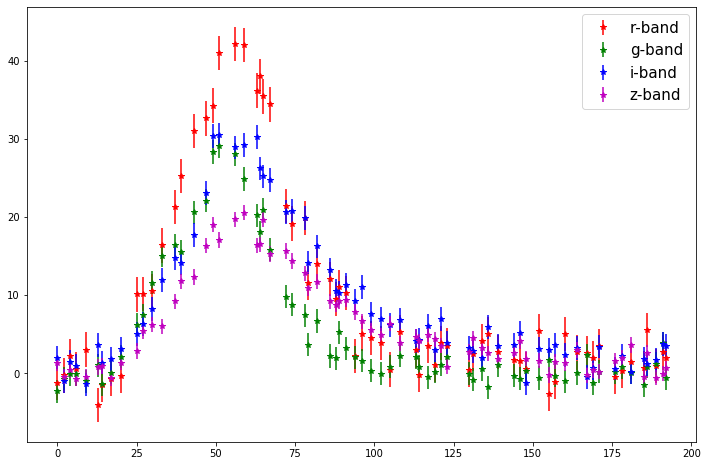

In [5]:
inp_path='Alex_simulated_data/'
bands=['lsstg','lsstr','lssti','lsstz']
fileN='Alex_sim_nobs_70_fluc2_t1_40_mu_2.2_4.2_dt_1.5_20.3'

fileNr=inp_path+fileN+bands[1]+'.txt';#print(fileNr)
fileNg=inp_path+fileN+bands[0]+'.txt';#print(fileNg)
fileNi=inp_path+fileN+bands[2]+'.txt';#print(fileNi)
fileNz=inp_path+fileN+bands[3]+'.txt';#print(fileNz)

tr,fr,sigfr,fr1,fr2=np.loadtxt(fileNr,usecols=[0,1,2,3,4], unpack=True)
tg,fg,sigfg,fg1,fg2=np.loadtxt(fileNg,usecols=[0,1,2,3,4], unpack=True)
ti,fi,sigfi,fi1,fi2=np.loadtxt(fileNi,usecols=[0,1,2,3,4], unpack=True)
tz,fz,sigfz,fz1,fz2=np.loadtxt(fileNz,usecols=[0,1,2,3,4], unpack=True)

print("No. of data points in r,g,i,z bands=",len(tr), len(tz),len(ti),len(tz),"respectively\n")

t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti), np.amin(tz)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti), np.amax(tz)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

#we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; tz=tz-t_min;

t_max=t_max-t_min; t_min=0.0;

clr=['r','g','b','k']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt="r*",label=r"r-band")
plt.errorbar(tg,fg,yerr=sigfg,fmt="g*",label=r"g-band")
plt.errorbar(ti,fi,yerr=sigfi,fmt="b*",label=r"i-band")
plt.errorbar(tz,fz,yerr=sigfz,fmt="m*",label=r"z-band")
plt.legend(loc=0,fontsize=15)


fro=fr1+fr2;fgo=fg1+fg2;fio=fi1+fi2;fzo=fz1+fz2
chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
print("Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.")
print("\nChi^2 original: r-band=",chisqro,"g-band=",chisqgo,"i-band=",chisqio,"z-band=",chisqzo)


First we try the template 2, equ(20) of our report, with crossing statistics up to order 2, see equ(18).
Here we model the earlier image using the template+crossing statics, relative amplitude and time delay should describe the later image.

The system has two images:  𝜇=2.2,4.2  and  𝑑𝑡=1.5,20.3 . Since, here we mainly model the earlier image with the intrinsic flux model, we expect to find  𝜇=4.2/2.2=1.909  and  𝑑𝑡=20.3−1.5=18.8 .

In [6]:
mu_des=4.2/2.2; dt_des=18.8;# expected mu and dt after fitting

In [7]:
#template 2: t^n exp(-t/tk); stretch, crossing statistics upto 2nd order

def mod2(x,dt,t0,n,xk,s,c0,c1,c2,c3,c4):
    x=x-t0;
    xmax=np.amax(x);
    x=x-dt;
    
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('nr', 2.0, True, 1.0,4.0), ('tkr', 10.0, True, 1.0,40.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('ng', 2.0, True, 1.0,4.0), ('tkg', 10.0, True, 1.0,40.0),('sg', 0.01,True, 0.0,0.99))#, ;

p.add_many(('mu1', 0.58, True, 0.4,2.5),('dt1',1.0, True,0,25.0) ,('t0',10.0, True,0.0,60.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0, False, -10,10) ,('c4r', 0.0,False, None,None))

p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0, False, -10,10) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 2.0, True, 1.0,4.0), ('tki', 10.0, True, 1.0,40.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, -10,10))

p.add_many(('nz', 2.0, True, 1.0,4.0), ('tkz', 10.0, True, 1.0,40.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod2(tr,0,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod2(tr,v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod2(tg,0,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod2(tg,v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod2(ti,0,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)
            +v['mu1']*mod2(ti,v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)-fi)/sigfi;
    
    B4=(mod2(tz,0,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)
            +v['mu1']*mod2(tz,v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res2 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=10000, steps=100000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res2.params)

100%|██████████| 100000/100000 [1:36:37<00:00, 17.25it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9014.96580125 11968.89926945 12211.23430959  9101.63094358
 11329.70071604  9734.81173365  5401.79699076  1709.93039939
  3788.92618368 12020.47076928 12011.77746687 12022.74490414
  9492.62353366 10889.3910292   9505.17496374  8154.62664856
 12260.31869093 12149.37790195 11654.92452231 11543.56553127
 11689.62852596  7241.16781483 11933.89648982 11425.66973255
 12218.46552561 12265.57726624 12212.25865291  3421.89940236]
[[Variables]]
    nr:         1.50841197 +/- 0.17372468 (11.52%) (init = 2)
    tkr:        8.40394313 +/- 3.13013721 (37.25%) (init = 10)
    sr:         0.53961273 +/- 0.16770100 (31.08%) (init = 0.01)
    ng:         1.39666912 +/- 0.28270070 (20.24%) (init = 2)
    tkg:        5.31825292 +/- 1.75459234 (32.99%) (init = 10)
    sg:         0.34006469 +/- 0.23412437 (68.85%) (init = 0.01)
    mu1:     

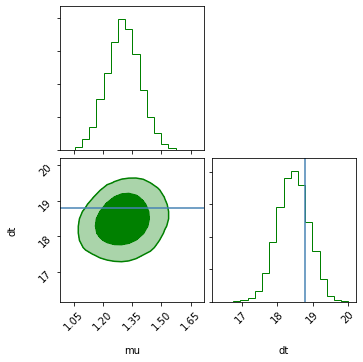

In [8]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res2.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([mu_des,dt_des]))

The results are off the expectation. Time delay is found correctly but not the relative amplification $\mu$. 

Below we try to see how the reconstructions from the maximum likelihood estimation (MLE) of the fitting look like.


Maximum likelihood Estimation
-----------------------------


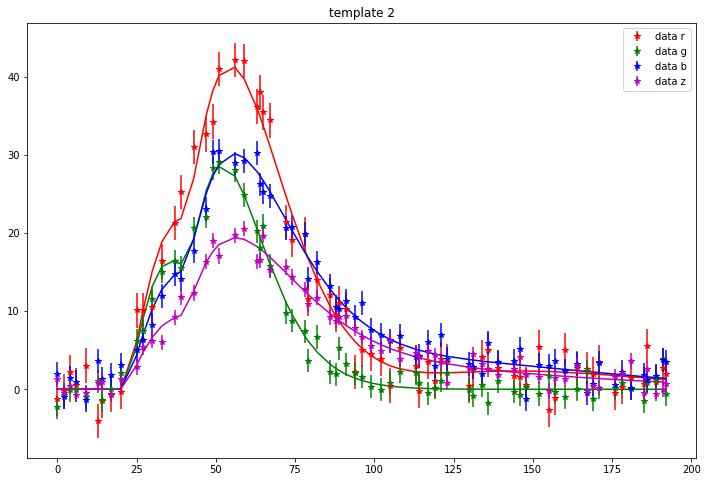

Maximum liklihood: mu= 1.2849088116218779 dt= 18.81923514503598
Chi^2 r= 77.23459854676457 Chi^2 g= 55.47641549237252 Chi^2 i= 75.39026910852992 Chi^2 z= 91.81677584974709
Chi^2 original: r= 71.94484533049948 g= 56.730339309444396 Chi^2 i= 74.01293178400795 Chi^2 z= 93.95065584230706


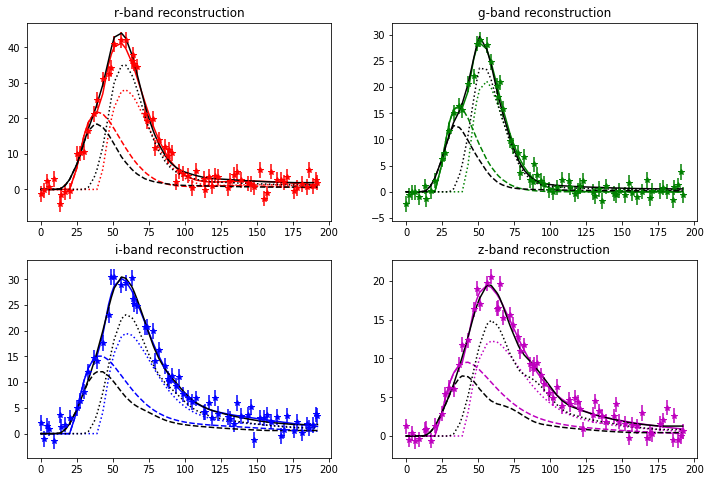

In [10]:
def plot_func2(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [nrm,tkrm,srm,ngm,tkgm,sgm,mum,dtm,t0m,c0rm,c1rm,c2rm,c0gm,c1gm,c2gm,
     nim,tkim,sim,c0im,c1im,c2im,nzm,tkzm,szm,c0zm,c1zm,c2zm,lnm]=mle_soln;
    #print(nrm,tkrm,ngm,tkgm,mum,dtm,t0m,c0rm,c1rm,c0gm,c1gm,c2gm,lnm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod2(tr,0,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod2(tr,dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod2(tg,0,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod2(tg,dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod2(ti,0,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod2(ti,dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod2(tz,0,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod2(tz,dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 2')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("Chi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()
    
plot_func2(res2)

Altough the individual images are not recovered correctly, the fitting to the combined light curves are good.  

After observing some more cases, I believe the model $t^2 \exp(-t/t_k)$, even together with crossing statistics, can not describe the light curve of any particular image (at least in this choice of simulation parameter). That is why, probably, we are getting excellent fit to the combined light curves but the individual image lc's are not correctly recovered. 

Next we try log-normal template (template 1,equ (19)) with crossing statistics up to 2nd order.

In [11]:
#template 1: equ(19)
def mod(x,dt,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    xmax=np.amax(x);
    x=x-dt;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.5),('dt1',5.0, True,0,25.0) ,('t0',1.0, True,0.0,60.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.0, False, None,None) ,('c4r', 0.0,False, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.0,False, None,None) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, None,None))

p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,0,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr,v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,0,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg,v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod(ti,0,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)
            +v['mu1']*mod(ti,v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)-fi)/sigfi;
    
    B4=(mod(tz,0,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            +v['mu1']*mod(tz,v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=10000, steps=100000, thin=3, nwalkers=200,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res.params)

100%|██████████| 100000/100000 [2:27:53<00:00, 11.27it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 5804.27082256  4042.45635087  7229.33009214  4924.76377615
  3484.90056267  3966.6743136  11690.73261404 11303.01223945
 11674.37099264  5752.56384636  4996.91318283  7991.25324042
 10332.36294151  9791.27931486 10332.55466774  8255.2947641
  4625.67963443  5209.40424338 12047.79715368 12285.0320342
 11951.94013342  7260.81527422  6152.57522859  5626.05836929
  9848.48024302 10509.12258367  9721.35707401  8741.39700049]
[[Variables]]
    mu1:        1.43033177 +/- 0.13178492 (9.21%) (init = 1)
    dt1:        18.5582936 +/- 0.59665464 (3.22%) (init = 5)
    t0:         12.7747648 +/- 2.55278936 (19.98%) (init = 1)
    nr:         2.10634641 +/- 0.44372626 (21.07%) (init = 1)
    tkr:        0.47170198 +/- 0.04800677 (10.18%) (init = 0.1)
    sr:         0.73449918 +/- 0.10264084 (13.97%) (init = 0.01)
    c0r:        3981

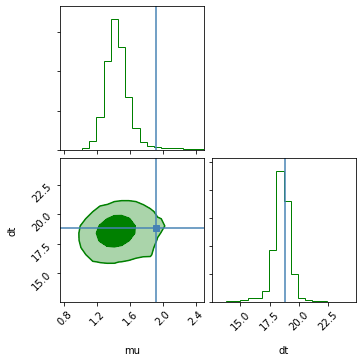

In [12]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([mu_des,dt_des]))

Not a great fit, but at least now we find our desired solution within $95\%$ contour. Let us see the MLE


Maximum likelihood Estimation
-----------------------------


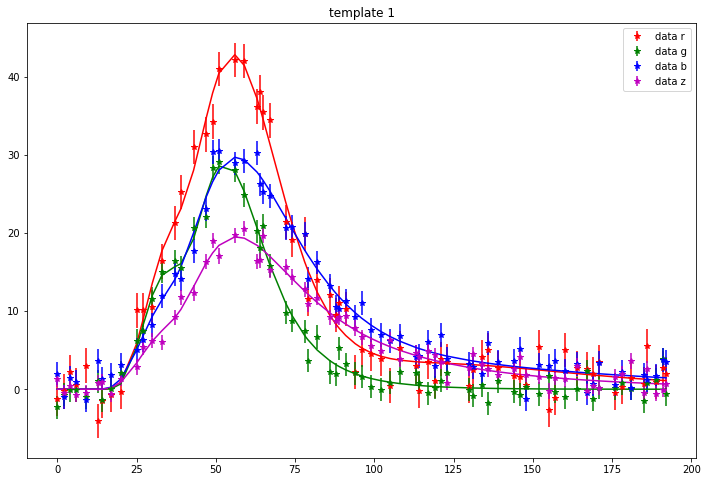

Maximum liklihood: mu= 1.47690162329382 dt= 18.714352376838015

Chi^2 r= 69.802412367275 Chi^2 g= 48.58187607569386 Chi^2 i= 74.83430679408202 Chi^2 z= 86.53420393824527
Chi^2 original: r= 71.94484533049948 g= 56.730339309444396 Chi^2 i= 74.01293178400795 Chi^2 z= 93.95065584230706


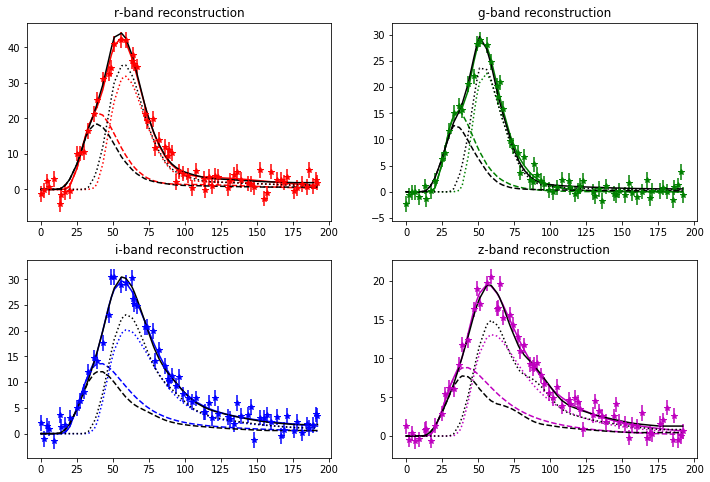

In [13]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [mum,dtm,t0m,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,#c3rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,#c3gm,
     nim,tkim,sim,c0im,c1im,c2im,
     nzm,tkzm,szm,c0zm,c1zm,c2zm,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,0,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Ps2r=mum*mod(tr,dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod(tg,0,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Ps2g=mum*mod(tg,dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod(ti,0,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod(ti,dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod(tz,0,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod(tz,dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    c4gm
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()

    
plot_func(res)

The best-fit recovered images are not bad. Note that we cannot use crossing statistics more than 2nd order because of the limitation of emcee handling many free parameters. 

Next we try the above in pystan (HMC): template 1 (eq(19)) with 2nd order crossing stat

In [14]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, real c0,real c1,real c2)//,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0));
                //+c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; //real c3r; real c4r;
    real c0g; real c1g; real c2g; //real c3g; real c4g;
    real c0i; real c1i; real c2i; //real c3i; real c4i;
    real c0z; real c1z; real c2z; //real c3z; real c4z;
    
    real<lower=0.4, upper=2.5> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=100000, chains=6, warmup=10000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_395d007470cb7cd0410d76affcec8fc4 NOW.


Inference for Stan model: anon_model_395d007470cb7cd0410d76affcec8fc4.
6 chains, each with iter=100000; warmup=10000; thin=3; 
post-warmup draws per chain=30000, total post-warmup draws=180000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr   3.77     0.1   0.37   2.35    3.8   3.86   3.92   4.01     12   1.83
sigr     0.5    0.01   0.06    0.4   0.46   0.49   0.53   0.63     26   1.14
sr      0.49  4.3e-3   0.28   0.03   0.25   0.49   0.74   0.96   4342    1.0
meang   3.11    0.08   0.36   2.26   2.88   3.13   3.38   3.68     23   1.21
sigg    0.41    0.01   0.06    0.3   0.36    0.4   0.44   0.57     21   1.22
sg      0.49  4.4e-3   0.29   0.02   0.25   0.49   0.74   0.97   4215    1.0
meani   3.87    0.02   0.13   3.59   3.81   3.88   3.94   4.06     51   1.09
sigi    0.55    0.02   0.08   0.43   0.49   0.53   0.58   0.77     20   1.25
si       0.5  4.2e-3   0.28   0.03   0.25   0.49   0.74   0.97   4522    1.0
meanz   3.55    0.15   0.54   2.11 

**I have no idea why pystan faces these weired problems while sampling. In these sampling (template1 and 2 both) n_eff and Rhat always indicate some problem. I am working on this.**

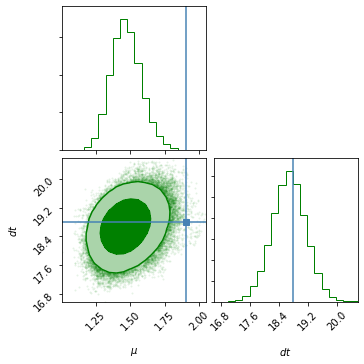

In [15]:
def contour(fit):
    #print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=1,
                           truths=list([mu_des,dt_des]))
    #return fig
    
contour(fit3)

With the same setup now the desired point is outside $2-sigma$! That is possibly because with HMC we now have much smaller contour in $\mu$.

Below we try the same with crossing statistics upto 4th order. We also put less strict prior on $\mu$.

In [16]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, 
    real c0,real c1,real c2,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0)
                +c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; real c3r; real c4r;
    real c0g; real c1g; real c2g; real c3g; real c4g;
    real c0i; real c1i; real c2i; real c3i; real c4i;
    real c0z; real c1z; real c2z; real c3z; real c4z;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i,c3i,c4i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i,c3i,c4i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=100000, chains=6, warmup=10000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db9474f7a9b75da229d403b01bc19d57 NOW.


Inference for Stan model: anon_model_db9474f7a9b75da229d403b01bc19d57.
6 chains, each with iter=100000; warmup=10000; thin=3; 
post-warmup draws per chain=30000, total post-warmup draws=180000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr    3.2    0.23   0.47   2.29   2.79   3.34   3.59   3.85      4   2.31
sigr    0.53    0.02   0.08    0.4   0.48   0.53   0.59    0.7     12   1.42
sr      0.51    0.01   0.28   0.04   0.27   0.52   0.75   0.97    391   1.01
meang   2.74    0.16   0.39   2.04   2.43   2.76    3.0   3.51      6   1.75
sigg    0.45    0.03   0.08    0.3    0.4   0.45   0.51    0.6      9   1.49
sg      0.52    0.02   0.29   0.03   0.27   0.52   0.77   0.97    234   1.04
meani   3.03    0.19   0.53   1.95   2.61   3.12   3.46   3.83      8   1.69
sigi    0.62    0.05   0.14   0.42   0.51   0.59   0.71   0.94      9   1.48
si      0.49    0.02    0.3   0.02   0.23   0.48   0.75   0.97    301   1.02
meanz   2.82    0.23   0.55   1.88 

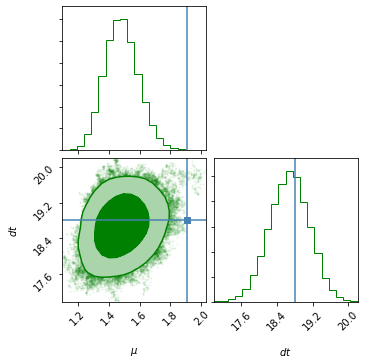

In [17]:
contour(fit4)

The result is consistent with the above HMC sampling, not with the emcee samling!

Below we try template2 + strecth + 4th order crossing stat in HMC.

In [18]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, 
    real c0,real c1,real c2,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                //fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx[i]=pow(x,sig)*exp(-x/mean);
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0)
                +c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=30.0> meanr; real<lower=0.0, upper=4.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=30.0> meang; real<lower=0.0, upper=4.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=30.0> meani; real<lower=0.0, upper=4.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=30.0> meanz; real<lower=0.0, upper=4.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; real c3r; real c4r;
    real c0g; real c1g; real c2g; real c3g; real c4g;
    real c0i; real c1i; real c2i; real c3i; real c4i;
    real c0z; real c1z; real c2z; real c3z; real c4z;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=60.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i,c3i,c4i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i,c3i,c4i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit5 = sm.sampling(data=data, iter=6000, chains=6, warmup=600, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit5)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1a728dcd076e676937c478e2443e9252 NOW.


Inference for Stan model: anon_model_1a728dcd076e676937c478e2443e9252.
6 chains, each with iter=6000; warmup=600; thin=3; 
post-warmup draws per chain=1800, total post-warmup draws=10800.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr  15.68    0.49   2.24  11.54  14.12  15.61  17.14  20.39     21   1.19
sigr     0.6    0.02   0.23   0.19   0.45   0.58   0.75   1.09     86   1.07
sr      0.49    0.01   0.28   0.03   0.25   0.49   0.73   0.96    457   1.01
meang   7.02    0.05   0.44    6.2   6.72    7.0   7.29   7.92     64   1.09
sigg    0.16    0.02   0.13 5.3e-3   0.06   0.13   0.23   0.49     30   1.17
sg      0.48    0.01   0.29   0.02   0.23   0.48   0.73   0.96    697    1.0
meani  19.96     0.5    2.4  16.25  18.37   19.7  21.15   26.4     23   1.34
sigi    0.12  7.2e-3    0.1 4.6e-3   0.04   0.09   0.17   0.38    201   1.03
si       0.5    0.01   0.28   0.03   0.26    0.5   0.74   0.96    516    1.0
meanz  18.61     0.8    2.5  14.44  16.92

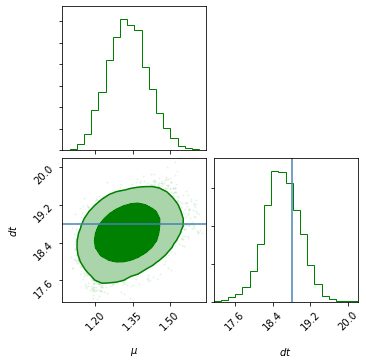

In [19]:
contour(fit5)

So template 2 with 4th order crossing stat is giving us bad results (although here the number of step is relatively small).  

Comparing "crossing5_correct.ipynb" (fluc=1) with "crossing6_correct.ipynb" (fluc=2), we can conclude that when the fluctuation in observation days is small (fluc=1), template 1 (log-normal)+ stretch+crossing statistics can give us correct fitting.